# Synthetic Experiment: Understanding Prototypical Ensembles under Subpopulation Shift

This notebook replicates a simplified version of the experimental pipeline described in our ICML 2025 paper, *Diverse Prototypical Ensembles Improve Robustness to Subpopulation Shift*. The goal is to illustrate how diverse prototype classifiers behave under structured subpopulation distributions, and how combining them can improve performance on underrepresented groups.

Each section below corresponds to a key step in the experiment.

---

In [1]:
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2

# importing utility functions for data generation, visualization, and model training. A fixed random seed is set to ensure reproducibility.
from notebooks.utils_synthetic import *
from notebooks.utils_plot import *
from utils.misc import fix_random_seed
fix_random_seed(2)

### 1. Data Generation and Visualization

We generate a synthetic 2D dataset composed of several clusters, each representing a subgroup. The training set is sampled with an imbalanced distribution over these subgroups, while the test set is sampled to ensure equal representation.

The synthetic dataset includes two classes, each drawn from multiple Gaussian clusters. Each class is composed of several subgroups, which simulate latent attributes. The majority of samples in each class are concentrated in one dominant subgroup (associated with Attribute 1), while smaller, minority subgroups are defined by Attributes 2 and 3. This setup reflects the subpopulation shift scenario where certain attribute combinations are underrepresented during training, potentially leading to biased decision boundaries.


> This synthetic setup models a subpopulation shift scenario where the test distribution differs from the biased training distribution.

---

<Axes: title={'center': 'Test Data\n(attribute balance)'}>

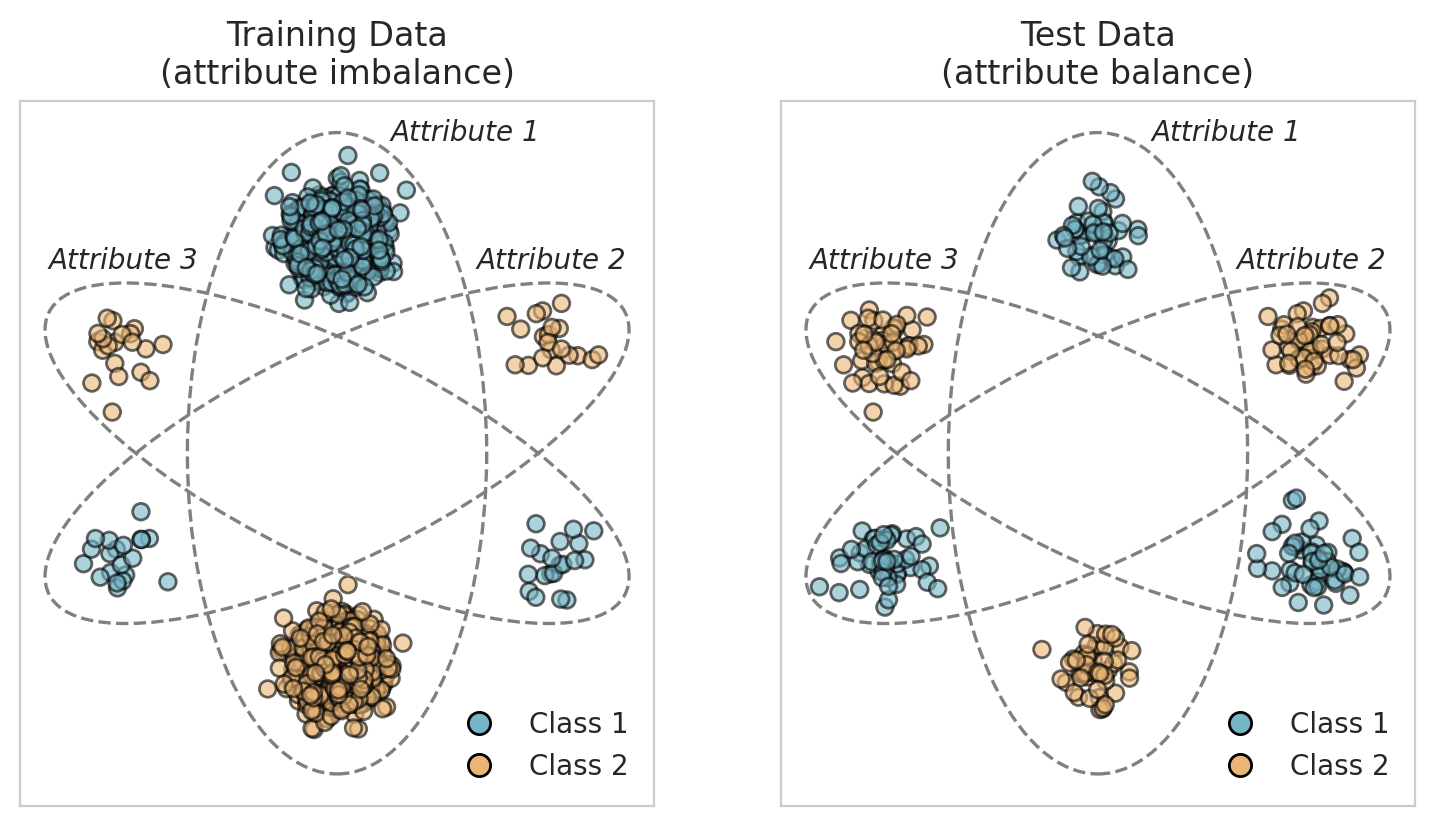

In [2]:
# Step 1: Generate Clusters
X_train, y_train, subgroups_train = generate_clusters(total_samples=2000, random_state=42)
X_test, y_test, subgroups_test = generate_balanced_clusters(total_samples=300, random_state=42)
_, axes = plt.subplots(1, 2, figsize=(9, 5), dpi=200)
plot_clusters(X_train, y_train, title="Training Data\n(attribute imbalance)", ax=axes[0])
plot_clusters(X_test, y_test, title="Test Data\n(attribute balance)", ax=axes[1])

### 2. Baseline Model Training
A prototype-based classifier is trained using all available training data. The model is evaluated by computing accuracy on each subgroup and visualizing distances to the Class 1 prototype (the blue ★).

> This model acts as the baseline (similar to ERM in our paper), and typically shows uneven performance across subgroups due to the sampling bias in training.

---

Training samples: 2,000, Testing samples: 300


Epoch 4/4: 100%|██████████| 125/125 [00:00<00:00, 262.95it/s, acc=96.00%, loss=0.159] 



Averaged Training Accuracy: 96.00%
[Training Set] Per-Group Accuracy:
  Group 0 (Attribute 1): 100.0%
  Group 1 (Attribute 1): 100.0%
  Group 2 (Attribute 2): 0.0%
  Group 3 (Attribute 2): 0.0%
  Group 4 (Attribute 3): 0.0%
  Group 5 (Attribute 3): 0.0%

Averaged Test Accuracy: 33.33%
[Test Set] Per-Group Accuracy:
  Group 0 (Attribute 1): 100.0%
  Group 1 (Attribute 1): 100.0%
  Group 2 (Attribute 2): 0.0%
  Group 3 (Attribute 2): 0.0%
  Group 4 (Attribute 3): 0.0%
  Group 5 (Attribute 3): 0.0%


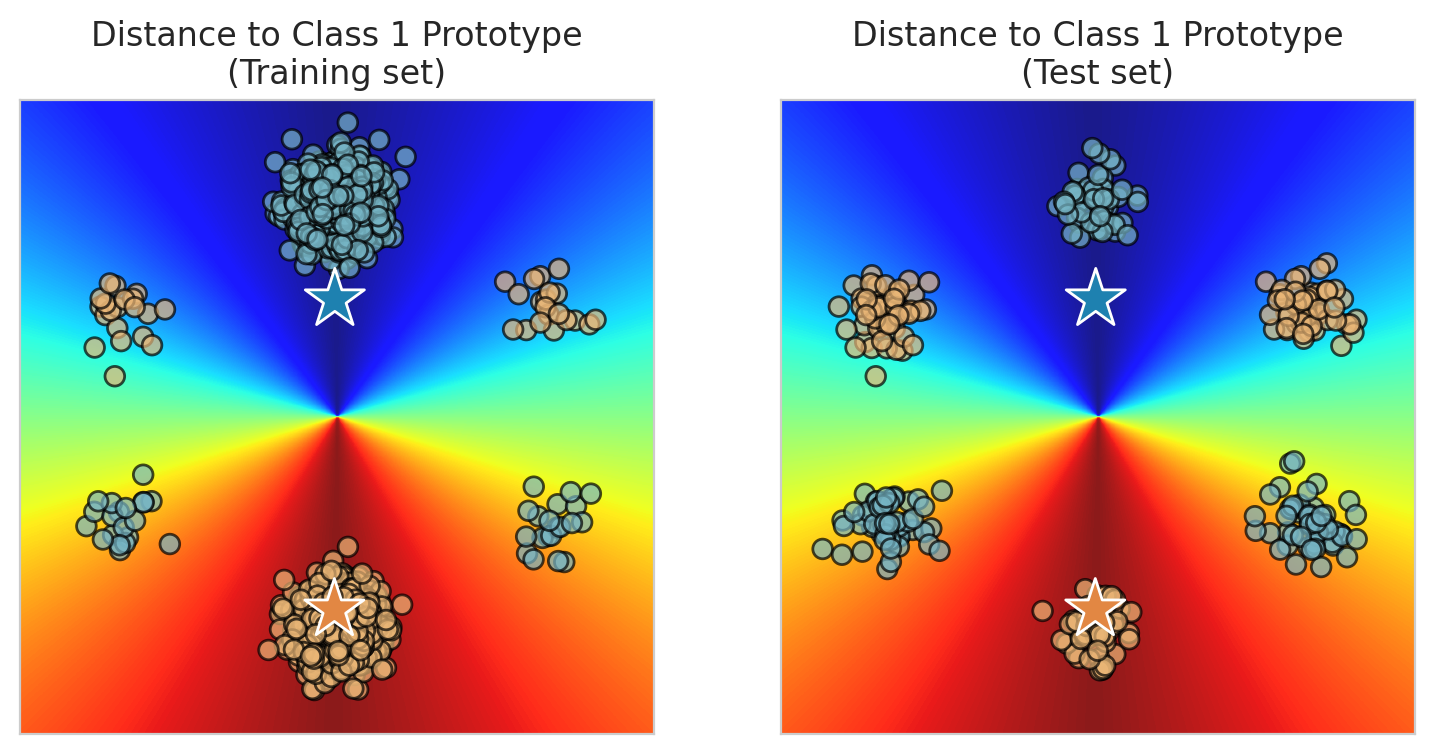

In [3]:
# Create DataLoaders
training_loader, test_loader, train_size, test_size = create_dataloaders(X_train, y_train, X_test, y_test, batch_size=16)
_, training_eval_loader, *_ = create_dataloaders(X_train, y_train, X_train, y_train, batch_size=32)
print(f"Training samples: {train_size:,}, Testing samples: {test_size:,}")

# Train a single prototype on the entire training set. This will serve as the baseline.
input_dim = X_train.shape[1]
num_classes = 2  # Binary classification
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = train_model(training_loader, test_loader, input_dim, num_classes, device=device, epochs=4, lr=1e-3, entropic_scale=1, optim_name='sgd')

# Visualization of distance to Class 1 prototype (the blue star)
model.eval()
_, axes = plt.subplots(1, 2, figsize=(9, 5), dpi=200)
plot_distance_to_first_class(model, X_train, y_train, ax=axes[0])
plot_distance_to_first_class(model, X_test, y_test, ax=axes[1], set_name="Test")

# === Evaluate on Training Set ===
correct, true_pos = evaluate_model(model, training_eval_loader, device, set_name='Training')

subgroups_train_unique, counts = np.unique(subgroups_train, return_counts=True)
per_group_acc_train = [(sum(true_pos[subgroups_train == g]) / count).item() for g, count in zip(subgroups_train_unique, counts)]

print(f"\nAveraged Training Accuracy: {100 * correct / (len(training_eval_loader.dataset)):.2f}%")
print("[Training Set] Per-Group Accuracy:")
for g, acc in zip(subgroups_train_unique, per_group_acc_train):
    if g in [0, 1]:
        attr = "Attribute 1"
    elif g in [2, 3]:
        attr = "Attribute 2"
    elif g in [4, 5]:
        attr = "Attribute 3"
    else:
        attr = "Unknown"
    print(f"  Group {g} ({attr}): {acc * 100:.1f}%")

# === Evaluate on Test Set ===
correct, true_pos = evaluate_model(model, test_loader, device)
subgroups_test_unique, counts = np.unique(subgroups_test, return_counts=True)
per_group_acc_test = [(sum(true_pos[subgroups_test == g]) / count).item() for g, count in zip(subgroups_test_unique, counts)]

print(f"\nAveraged Test Accuracy: {100 * correct / (len(test_loader.dataset)):.2f}%")
print("[Test Set] Per-Group Accuracy:")
for g, acc in zip(subgroups_test_unique, per_group_acc_test):
    if g in [0, 1]:
        attr = "Attribute 1"
    elif g in [2, 3]:
        attr = "Attribute 2"
    elif g in [4, 5]:
        attr = "Attribute 3"
    else:
        attr = "Unknown"
    print(f"  Group {g} ({attr}): {acc * 100:.1f}%")

The plots visualize the model's learned decision surface by coloring the input space according to the softmax-normalized distance to the prototype of **Class 1** (blue star).

Each background color indicates the model’s confidence in classifying a region as **Class 1**:
- **Warmer colors** (e.g., red/yellow) indicate **lower confidence** or **greater distance** to the Class 1 prototype.
- **Cooler colors** (e.g., blue/green) indicate **higher confidence** or **closer proximity** to Class 1.

The overlaid scatter points show the training (or test) samples colored by their ground-truth class:
- Blue points: Class 1
- Orange points: Class 2

The large star markers denote the learned prototype locations for each class. These prototypes define the decision regions.

### 3. Training on Disjoint Subgroups

We train three separate models, each on a distinct slice of the subgroups:
- Model 1: trained on `subgroups < 2`
- Model 2: trained on `2 ≤ subgroups < 4`
- Model 3: trained on `subgroups > 3`

Each model is evaluated individually on the test set.

> These models are trained independently and specialize on different regions of the data. Their combined outputs will later form the ensemble.

---


[Training Subsample] Samples: 1,920  |  Testing Samples: 300


Epoch 4/4: 100%|██████████| 240/240 [00:01<00:00, 201.87it/s, acc=100.00%, loss=0.100]



[Training Subsample] Samples: 40  |  Testing Samples: 300


Epoch 4/4: 100%|██████████| 5/5 [00:00<00:00, 222.59it/s, acc=100.00%, loss=0.136]



[Training Subsample] Samples: 40  |  Testing Samples: 300


Epoch 4/4: 100%|██████████| 5/5 [00:00<00:00, 192.74it/s, acc=100.00%, loss=0.138]



[Attribute 1] Per-Group Accuracy on Training Set:
  Group 0: 100.0%
  Group 1: 100.0%
  Group 2: 0.0%
  Group 3: 0.0%
  Group 4: 0.0%
  Group 5: 0.0%
[Attribute 1] Per-Group Accuracy on Test Set:
  Group 0: 100.0%
  Group 1: 100.0%
  Group 2: 0.0%
  Group 3: 0.0%
  Group 4: 0.0%
  Group 5: 0.0%

[Attribute 2] Per-Group Accuracy on Training Set:
  Group 0: 0.0%
  Group 1: 0.0%
  Group 2: 100.0%
  Group 3: 100.0%
  Group 4: 0.0%
  Group 5: 0.0%
[Attribute 2] Per-Group Accuracy on Test Set:
  Group 0: 0.0%
  Group 1: 0.0%
  Group 2: 100.0%
  Group 3: 100.0%
  Group 4: 0.0%
  Group 5: 0.0%

[Attribute 3] Per-Group Accuracy on Training Set:
  Group 0: 0.0%
  Group 1: 0.0%
  Group 2: 0.0%
  Group 3: 0.0%
  Group 4: 100.0%
  Group 5: 100.0%
[Attribute 3] Per-Group Accuracy on Test Set:
  Group 0: 0.0%
  Group 1: 0.0%
  Group 2: 0.0%
  Group 3: 0.0%
  Group 4: 100.0%
  Group 5: 100.0%


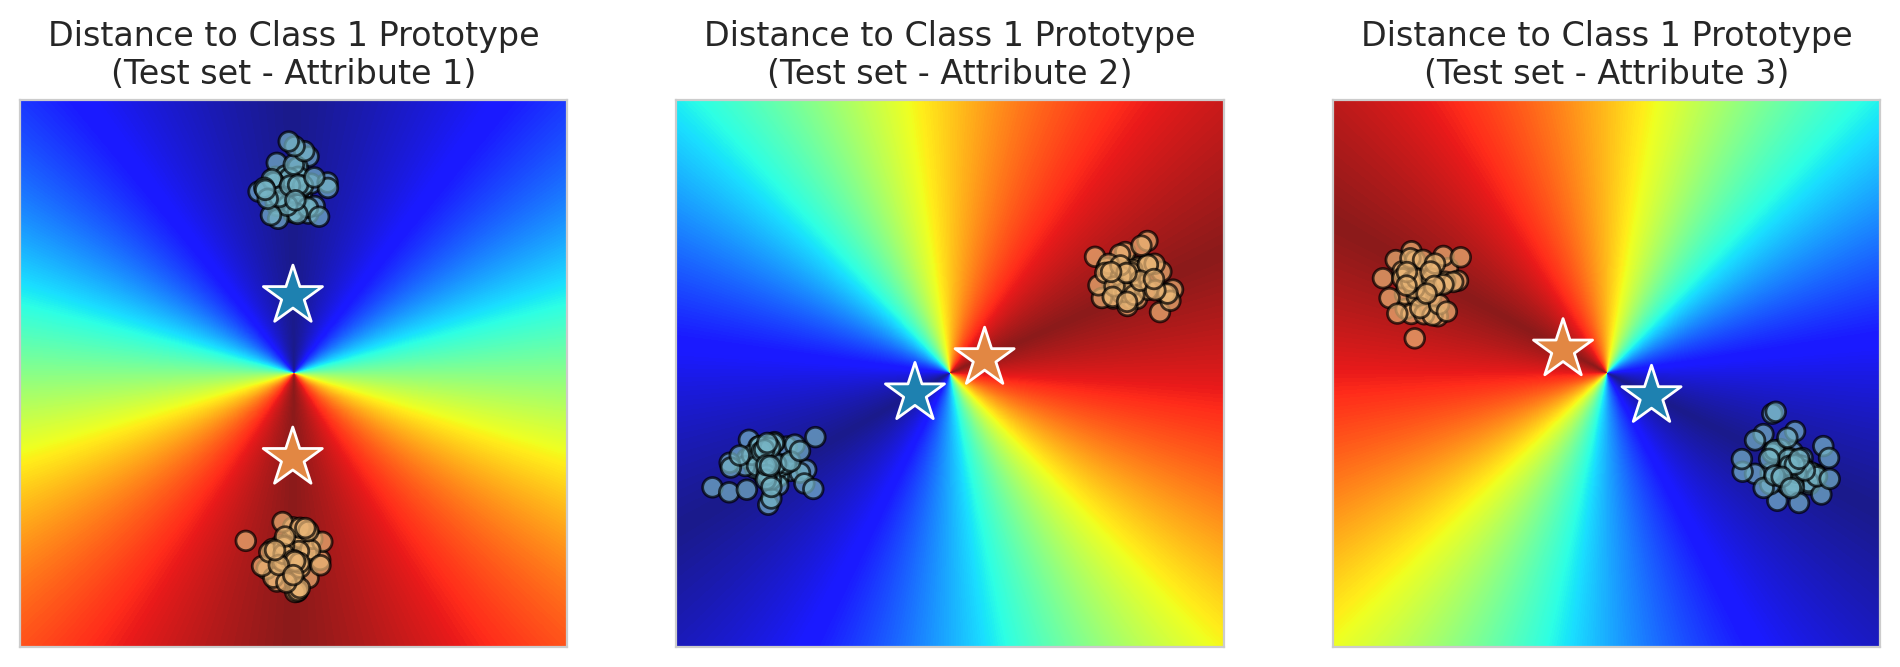

In [4]:
def train_subsampled(condition, condition_test=None, ax=None, note=''):
    # Create DataLoaders on subgroup slice
    training_loader, test_loader, train_size, test_size = create_dataloaders(
        X_train[condition], y_train[condition], X_test, y_test, batch_size=8)
    _, training_eval_loader, *_ = create_dataloaders(X_train, y_train, X_train, y_train, batch_size=32)

    print(f"\n[Training Subsample] Samples: {train_size:,}  |  Testing Samples: {test_size:,}")

    # Train the Model
    input_dim = X_train.shape[1]
    num_classes = 2
    device = 'cuda' if torch.cuda.is_available() else 'cpu'

    model = train_model(
        training_loader, test_loader, input_dim, num_classes,
        device=device, epochs=4, lr=1e-3, optim_name='sgd', entropic_scale=1
    )
    evaluate_model(model, test_loader, device)

    if condition_test is not None:
        model.eval()
        plot_distance_to_first_class(
            model, X_test[condition_test], y_test[condition_test],
            ax=ax, set_name="Test", note=note
        )
    return model


_, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
models = [
    train_subsampled(subgroups_train < 2, subgroups_test < 2, ax=axes[0], note=' - Attribute 1'),
    train_subsampled((subgroups_train > 1) & (subgroups_train < 4),
                     (subgroups_test > 1) & (subgroups_test < 4),
                     ax=axes[1], note=' - Attribute 2'),
    train_subsampled(subgroups_train > 3, subgroups_test > 3, ax=axes[2], note=' - Attribute 3')
]

# Evaluate all models
for i, model in enumerate(models):
    attr_name = f"Attribute {i+1}"

    # Evaluate on Training Set
    correct, true_pos = evaluate_model(model, training_eval_loader, device, set_name='Training')
    subgroups_train_unique, counts = np.unique(subgroups_train, return_counts=True)
    per_group_acc = [(sum(true_pos[subgroups_train == g]) / count).item() for g, count in zip(subgroups_train_unique, counts)]

    print(f"\n[{attr_name}] Per-Group Accuracy on Training Set:")
    for g, acc in zip(subgroups_train_unique, per_group_acc):
        print(f"  Group {g}: {acc * 100:.1f}%")

    # Evaluate on Test Set
    correct, true_pos = evaluate_model(model, test_loader, device)
    subgroups_test_unique, counts = np.unique(subgroups_test, return_counts=True)
    per_group_acc = [(sum(true_pos[subgroups_test == g]) / count).item() for g, count in zip(subgroups_test_unique, counts)]

    print(f"[{attr_name}] Per-Group Accuracy on Test Set:")
    for g, acc in zip(subgroups_test_unique, per_group_acc):
        print(f"  Group {g}: {acc * 100:.1f}%")

### 4. Prototype Aggregation and Ensemble Visualization

We extract the prototypes and distance scales from the three models and aggregate them into a single ensemble. We then visualize the decision surface by plotting the distance to the first class across:
- 2 prototypes
- 4 prototypes
- 6 prototypes

> These visualizations show that adding more prototype heads leads to better coverage of the input space, which improves subgroup performance.

---

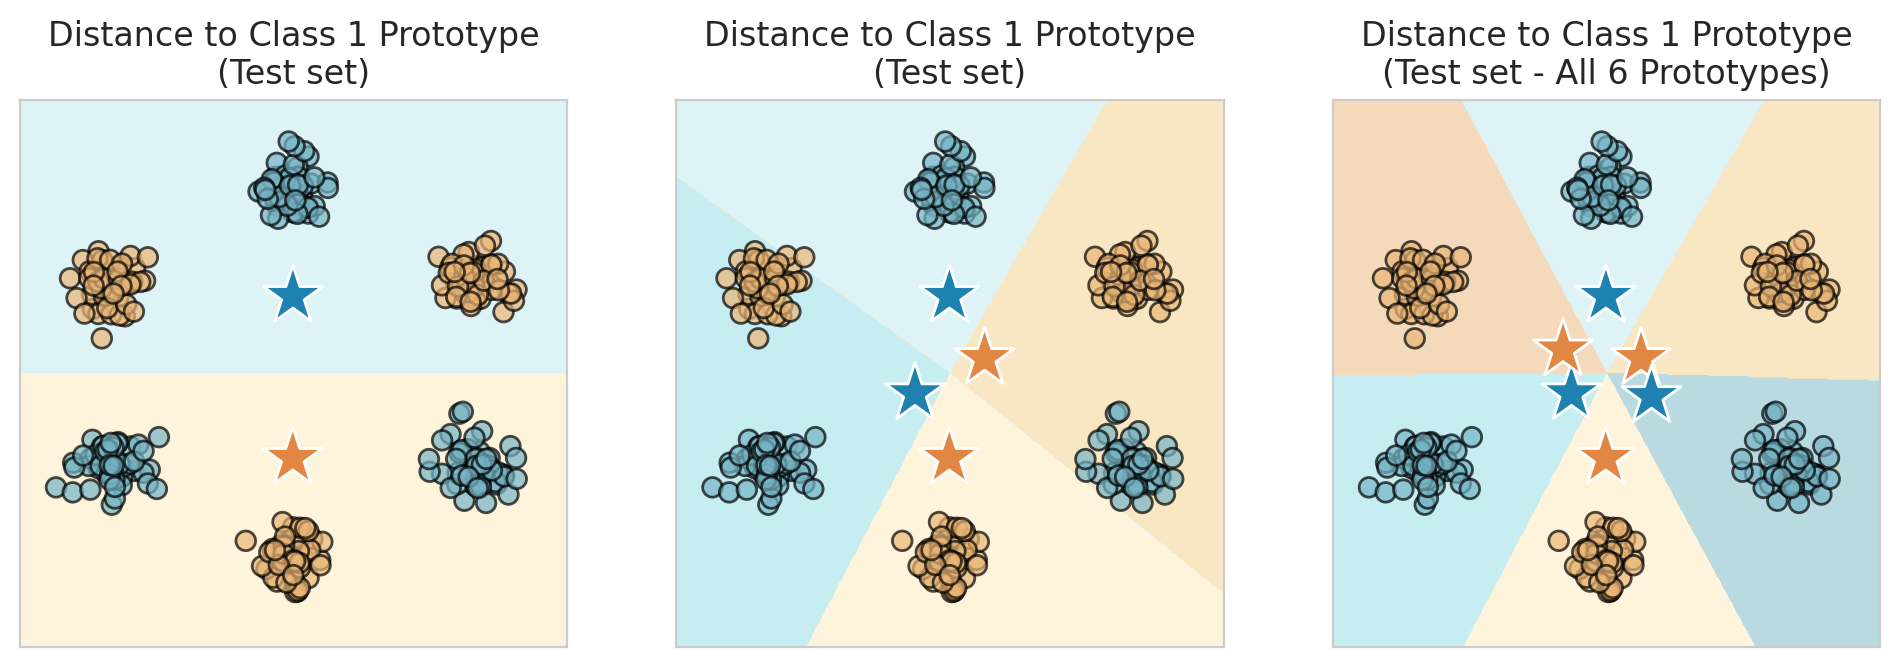

In [5]:
prototypes = torch.concat([_.prototypes.detach().cpu() for _ in models]).numpy().astype('float32')
distance_scales = torch.concat([_.distance_scale.detach().cpu() for _ in models]).float()
distance_scales = distance_scales.repeat((2, 1)).T.flatten()
# plot_voronoi_with_distances(prototypes, distance_scales, X_test, y_test)

_, axes = plt.subplots(1, 3, figsize=(12, 4), dpi=200)
plot_distance_to_first_class_v1(prototypes[:2], distance_scales[:2], X_test, y_test, ax=axes[0])
plot_distance_to_first_class_v1(prototypes[:4], distance_scales[:4], X_test, y_test, ax=axes[1])
plot_distance_to_first_class_v1(prototypes, distance_scales, X_test, y_test, ax=axes[2], note=' - All 6 Prototypes')

### 5. Voronoi Region Plotting

We visualize the Voronoi diagram defined by the learned prototypes. The regions indicate areas of influence for each prototype in the ensemble.

> This plot helps to interpret how the ensemble partitions the input space, particularly near subgroup boundaries.

---

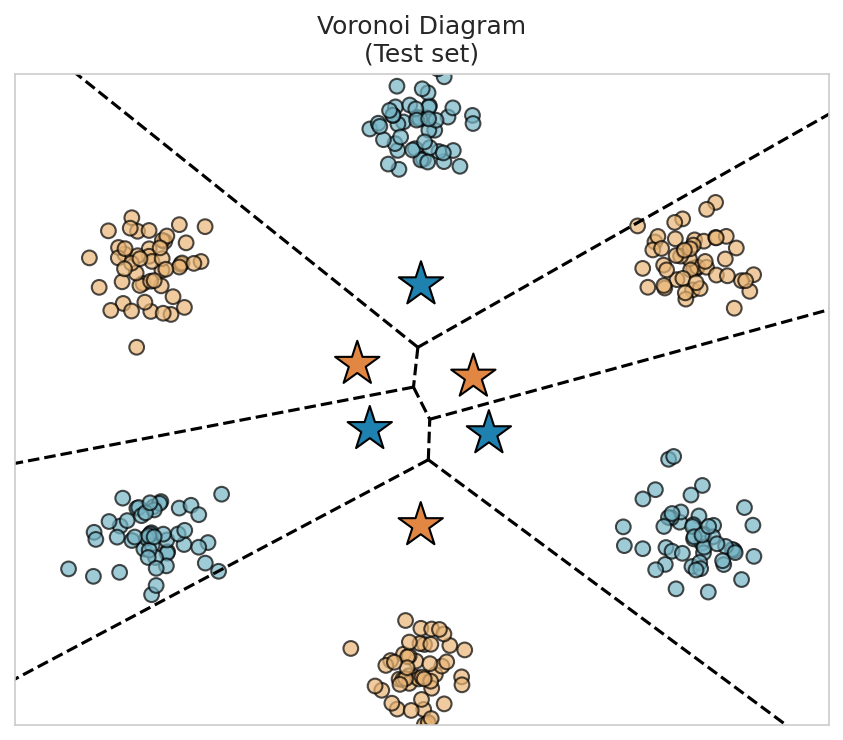

In [6]:
prototypes = torch.concat([_.prototypes.detach().cpu() for _ in models]).numpy().astype('float32')
distance_scales = torch.concat([_.distance_scale.detach().cpu() for _ in models]).float()
distance_scales = distance_scales.repeat((2, 1)).T.flatten()

plot_voronoi(prototypes, distance_scales, X_test, y_test, set_name="Test")

This notebook provides an interpretable view of how diverse prototype heads trained on disjoint subgroups can be combined to improve performance under subpopulation shift. The results support the key findings from our paper.

More experimental results and benchmark analyses are available at:
[https://minhto2802.github.io/diversified_prototypical_ensemble](https://minhto2802.github.io/diversified_prototypical_ensemble)